In [18]:
# 1. 데이터 불러오기
import pandas as pd
df = pd.read_csv("df_solar_real_final_yearmonthdaydate.csv", encoding = "utf-8")

In [19]:
df.head(3)

,발전구분,year,month,day,weekday,설비용량(MW),시간,발전량(kWh),연식(년),지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),하늘상태,태양고도,방위각
0,세종시폐기물매립장태양광,2017,1,1,6,1.628,1,0.0,4.6,청주,2.2,0.0,0.2,0.0,78.0,0.0,0.0,NaN,0.0,NaN
1,안산연성정수장태양광,2017,1,1,6,1.490,1,0.0,4.4,수원,0.1,0.0,0.3,0.0,96.0,0.0,0.0,NaN,0.0,NaN
2,영암에프원태양광b,2017,1,1,6,13.296,1,0.0,4.1,목포,5.0,0.0,1.8,160.0,93.0,0.0,0.0,NaN,0.0,NaN


In [20]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from sklearn.model_selection import RandomizedSearchCV

In [21]:
# 사용하고 싶은 피처 선택
features = [
    '발전구분', 'year', 'month', 'day', 'weekday', '시간',
    '설비용량(MW)', '연식(년)', '기온(°C)', '강수량(mm)', '풍속(m/s)',
    '풍향(16방위)', '습도(%)', '적설(cm)', '태양고도', '하늘상태','방위각'
]

In [22]:
target = '발전량(kWh)'

In [23]:
print(df.isnull().sum())

발전구분             0
year             0
month            0
day              0
weekday          0
설비용량(MW)         0
시간               0
발전량(kWh)        63
연식(년)            0
지점명              0
기온(°C)          23
강수량(mm)          1
풍속(m/s)         35
풍향(16방위)        35
습도(%)           45
일사(MJ/m2)        1
적설(cm)           1
하늘상태          9154
태양고도             0
방위각          99651
dtype: int64


In [24]:
df_model = df[features + [target]].dropna()

In [25]:
X = df_model[features]
y = df_model[target]

In [26]:
# 범주형 피처 지정
cat_features = ['발전구분']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [28]:
model = CatBoostRegressor(verbose=100, random_state=42) #verbose : 얼마나 자주 학습 상태를 출력할지 지정
model.fit(X_train, y_train, cat_features=cat_features)

Learning rate set to 0.081936
0:	learn: 2337.9066548	total: 250ms	remaining: 4m 9s
100:	learn: 662.5853855	total: 10.6s	remaining: 1m 34s
200:	learn: 621.8264201	total: 19.6s	remaining: 1m 18s
300:	learn: 598.4165461	total: 28.9s	remaining: 1m 7s
400:	learn: 579.4936402	total: 37.7s	remaining: 56.3s
500:	learn: 566.2861789	total: 46.1s	remaining: 45.9s
600:	learn: 554.2360201	total: 54.8s	remaining: 36.4s
700:	learn: 545.1206642	total: 1m 3s	remaining: 27s
800:	learn: 535.7429091	total: 1m 11s	remaining: 17.7s
900:	learn: 527.1504983	total: 1m 19s	remaining: 8.72s
999:	learn: 519.6309580	total: 1m 27s	remaining: 0us


In [29]:
# 예측
y_pred = model.predict(X_test)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# R² 점수 계산
r2 = r2_score(y_test, y_pred)

# 결과 출력
print("RMSE:", rmse) #한시간 당 평균 예측 오차 
print("R² Score:", r2) 


RMSE: 588.1706152727803
R² Score: 0.9458543686579702


In [30]:
# 중요도 추출
importances = model.get_feature_importance() 
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [31]:
# 중요도 출력
print(importance_df)

     Feature  Importance
6   설비용량(MW)   65.688480
14      태양고도    9.438467
15      하늘상태    8.410755
12     습도(%)    3.979479
5         시간    3.326220
7      연식(년)    1.771679
16       방위각    1.400756
0       발전구분    1.069709
8     기온(°C)    0.776520
11  풍향(16방위)    0.711739
10   풍속(m/s)    0.650380
2      month    0.629790
4    weekday    0.578297
3        day    0.563122
13    적설(cm)    0.450299
1       year    0.296848
9    강수량(mm)    0.257461


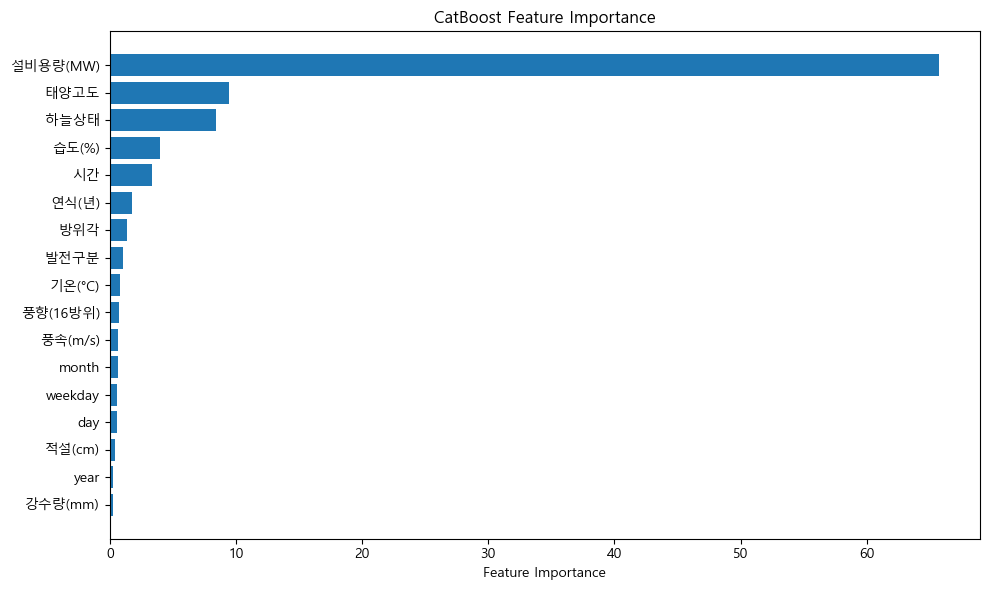

In [32]:
# 한글 폰트 설정 (Windows)
matplotlib.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # 가장 중요한 게 위로
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()

In [45]:
## RMSE / 평균 발전량(비율 기준)
mean_power = y_test.mean()
rmse_ratio = rmse / mean_power
print(f"RMSE 비율: {rmse_ratio:.2%}") 
# 10%이내 : 좋은 성능
# 20%이내 : 실용 가능
# 20% 이상 : 개선 필요

RMSE 비율: 38.31%
